In [2]:
import numpy as np
import time
import json
import csv
import os
import argparse
import math
import cv2
import glob
import shutil
import torch
import subprocess
from utils import *
from networks import *
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
import random
import models
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.models import resnet
from PIL import Image
import nvidia_smi
import psutil
import multiprocessing

## Weather classification

`label_to_weather(label)`: translate prediction result to a weather label.

`classify(infile)`: weather classification

In [3]:
def label_to_weather(label):
    if label == 0:
        return 'cloudy'
    elif label == 1:
        return 'foggy'
    elif label == 2:
        return 'rainy'
    elif label == 3:
        return 'shine'
    else:
        return 'sunrise'

In [4]:
!wget https://cnnorth1-modelarts-sdk.obs.cn-north-1.myhuaweicloud.com/modelarts-latest-py2.py3-none-any.whl
!pip install modelarts-latest-py2.py3-none-any.whl

--2020-11-30 13:33:13--  https://cnnorth1-modelarts-sdk.obs.cn-north-1.myhuaweicloud.com/modelarts-latest-py2.py3-none-any.whl
Resolving cnnorth1-modelarts-sdk.obs.cn-north-1.myhuaweicloud.com (cnnorth1-modelarts-sdk.obs.cn-north-1.myhuaweicloud.com)... 114.115.192.24
Connecting to cnnorth1-modelarts-sdk.obs.cn-north-1.myhuaweicloud.com (cnnorth1-modelarts-sdk.obs.cn-north-1.myhuaweicloud.com)|114.115.192.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680322 (664K) [binary/octet-stream]
Saving to: ‘modelarts-latest-py2.py3-none-any.whl.5’

modelarts-latest-py 100%[===================>] 664.38K  1.59MB/s    in 0.4s    

2020-11-30 13:33:14 (1.59 MB/s) - ‘modelarts-latest-py2.py3-none-any.whl.5’ saved [680322/680322]

Processing ./modelarts-latest-py2.py3-none-any.whl
  Attempting uninstall: modelarts
    Found existing installation: modelarts 1.1.3
    Uninstalling modelarts-1.1.3:
      Successfully uninstalled modelarts-1.1.3


In [5]:
import time
import re
import json
import psutil

def classify(infile):
    time1=time.time()
    # Read image

    predict_result = predictor_instance.predict(data=infile, data_type='images')    

    time2=time.time()
    print('Process image time:%s'%(time2-time1))
    memory = psutil.virtual_memory()
    cpu_percent = psutil.cpu_percent()
    print("Used memory:", memory.percent, "%")
    print("Used CPU:", cpu_percent, "%")

    #pprint.pprint(predict_result, depth=3)
    obj = json.loads(predict_result)    # obj now contains a dict of the data

    print('-' * 30)


    list= obj.get('scores')
    i = 1
    for item in list:
        print("No.%s %s: " % (i, item[0]) + "{:.4%}".format(item[1])) #item={'name': 'foggy', 'score': 0.9983261227607727}
        i = i + 1

    print('\nThe predicted result is ' + obj.get('predicted_label'))
    print('-' * 30)
    
    return obj.get('predicted_label')

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# # read image
# testing_img = mpimg.imread(filenamePath)
# # display image
# plt.imshow(testing_img)

In [5]:
def classify(infile):
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    model_path = "../vgg19_drop_batch_best_weights_256.h5"
    #Load the pre-trained models
    load_model_time = time.time()

    model = load_model(model_path)
    load_model_time = time.time() - load_model_time
    
#     info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
#     memory = psutil.virtual_memory()
#     cpu_percent = psutil.cpu_percent()
#     print("Used memory:", memory.percent, "%")
#     print("Used CPU:", cpu_percent, "%")
#     print("Total GPU memory:", info.total)
#     print("Free GPU memory:", info.free)
#     print("Used GPU memory:", info.used , "{:.1%}".format(info.used/info.total) )
#     print('---------------------')

    img_width, img_height = 256, 256

    # load image
    total_crop_time = 0
    
    total_crop_time = time.time()
    img = crop_image(infile, img_width, img_height)
    total_crop_time = time.time() - total_crop_time

    # classify image
    total_classify_time = 0
    total_classify_time = time.time()

    y_pred = model.predict(img, batch_size=1, verbose=1)
    classes = np.argmax(y_pred, axis = 1)
    image_labels = classes.tolist()
    
#     info2 = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
#     memory2 = psutil.virtual_memory()
#     cpu_percent2 = psutil.cpu_percent()
#     print("Used memory:", memory2.percent, "%")
#     print("Used CPU:", cpu_percent2, "%")
#     print("Free GPU memory:", info2.free)
#     print("Used GPU memory:", info2.used , "{:.1%}".format(info2.used/info2.total))
#     print('---------------------')

    total_classify_time = time.time() - total_classify_time
    
    print('weather classification completed.')
    print('load model time:', load_model_time)
    print('read image time: ', total_crop_time)
    print('classification time: ', total_classify_time)
    print('The classification result is',label_to_weather(image_labels[0]))

    print('---------------------')

    nvidia_smi.nvmlShutdown()

    label.value = image_labels[0]

## Adaptation models

`derain(infile, output_path, use_GPU, gpu_id)`

`defog(infile, output_path, use_GPU, gpu_id)`

In [6]:
def derain(infile, output_path, use_GPU, gpu_id):

    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    
    img_name = infile
    output_path = output_path
  
    if use_GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id

    total_time = time.time()

    os.makedirs(output_path, exist_ok=True)

    load_model_time = time.time()

    # Build model
    print('---------------------')
    print('Loading derain model ...')
    model = PReNet(6, use_GPU) #6 is number of recursive stages 
    #print_network(model)
    if use_GPU:
        model = model.cuda()
    model.load_state_dict(torch.load(os.path.join("logs/Rain1400/PReNet6/", "net_latest.pth")))
    #model.eval()

    load_model_time = time.time() - load_model_time
    print('load model time:', load_model_time)

    process_time = 0
    read_time = 0
    write_time = 0

    read_time = time.time()


    # input image
    y = cv2.imread(img_name)
    b, g, r = cv2.split(y)
    y = cv2.merge([r, g, b])
    #y = cv2.resize(y, (int(500), int(500)), interpolation=cv2.INTER_CUBIC)

    y = normalize(np.float32(y))
    y = np.expand_dims(y.transpose(2, 0, 1), 0)
    y = Variable(torch.Tensor(y), requires_grad=True)

    read_time = time.time() - read_time

#     print('---------------------')

#     info3 = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
#     memory = psutil.virtual_memory()
#     cpu_percent = psutil.cpu_percent()
#     print("Used memory:", memory.percent, "%")
#     print("Used CPU:", cpu_percent, "%")
#     print("Free GPU memory:", info3.free)
#     print("Used GPU memory:", info3.used , "{:.1%}".format(info3.used/info3.total) )
#     print('---------------------')


    if use_GPU:
        y = y.cuda()

    with torch.no_grad():
        if use_GPU:
            torch.cuda.synchronize()
        process_time = time.time()

        out, _ = model(y)
        out = torch.clamp(out, 0., 1.)

        if use_GPU:
            torch.cuda.synchronize()
        process_time = time.time() - process_time

    write_time = time.time()

#     info4 = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
#     memory4 = psutil.virtual_memory()
#     cpu_percent4 = psutil.cpu_percent()
#     print("Used memory:", memory4.percent, "%")
#     print("Used CPU:", cpu_percent4, "%")
#     print("Free GPU memory:", info4.free)
#     print("Used GPU memory:", info4.used , "{:.1%}".format(info4.used/info4.total))

#     print('---------------------')

    if use_GPU:
        save_out = np.uint8(255 * out.data.cpu().numpy().squeeze())   #back to cpu
    else:
        save_out = np.uint8(255 * out.data.numpy().squeeze())

    save_out = save_out.transpose(1, 2, 0)
    b, g, r = cv2.split(save_out)
    save_out = cv2.merge([r, g, b])

    derain_path = os.path.join(output_path, img_name.split("/")[-1])

    cv2.imwrite(derain_path, save_out)

    write_time = time.time() - write_time
    total_time = time.time() - total_time

    print('load derain model time:', load_model_time)
    print('read time:', read_time)
    print('process time:', process_time)
    print('write time:', write_time)
    print('total derain time: ', total_time)
    print("Output:", derain_path)
    print('---------------------')

    nvidia_smi.nvmlShutdown()

In [7]:
def defog(infile, output_path, use_GPU, gpu_id):
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

    if use_GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
    
    gpu_id = int(gpu_id)
    img_name = infile
    output_path = output_path

    write_time = 0

    total_time = time.time()
    load_model_time = time.time()

    print('---------------------')
    print('Loading defog model ...\n')

    encoder_lv1 = models.Encoder().cuda(gpu_id)
    encoder_lv2 = models.Encoder().cuda(gpu_id)
    encoder_lv3 = models.Encoder().cuda(gpu_id)

    decoder_lv1 = models.Decoder().cuda(gpu_id)
    decoder_lv2 = models.Decoder().cuda(gpu_id)
    decoder_lv3 = models.Decoder().cuda(gpu_id)

    encoder_lv1.load_state_dict(torch.load("./checkpoints/DMPHN_1_2_4/encoder_lv1.pkl"))
    encoder_lv2.load_state_dict(torch.load("./checkpoints/DMPHN_1_2_4/encoder_lv2.pkl"))
    encoder_lv3.load_state_dict(torch.load("./checkpoints/DMPHN_1_2_4/encoder_lv3.pkl"))

    decoder_lv1.load_state_dict(torch.load("./checkpoints/DMPHN_1_2_4/decoder_lv1.pkl"))
    decoder_lv2.load_state_dict(torch.load("./checkpoints/DMPHN_1_2_4/decoder_lv2.pkl"))
    decoder_lv3.load_state_dict(torch.load("./checkpoints/DMPHN_1_2_4/decoder_lv3.pkl"))

    load_model_time = time.time() - load_model_time
    
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    memory = psutil.virtual_memory()
    cpu_percent = psutil.cpu_percent()
    print("Used memory:", memory.percent, "%")
    print("Used CPU:", cpu_percent, "%")
    print("Free GPU memory:", info.free)
    print("Used GPU memory:", info.used , "{:.1%}".format(info.used/info.total))
    print('load model time:', load_model_time)
    print('---------------------')

    os.makedirs(output_path, exist_ok = True)

    with torch.no_grad():

        read_time = time.time()

        images_lv1 = transforms.ToTensor()(Image.open(img_name).convert('RGB'))
        images_lv1 = Variable(images_lv1 - 0.5).unsqueeze(0).cuda(gpu_id)
        # images_lv1 = Variable(images_lv1 - 0.5).unsqueeze(0)

        read_time = time.time() - read_time
        print('read time:', read_time)

        process_time = time.time()
        
        H = images_lv1.size(2)
        W = images_lv1.size(3)

        images_lv2_1 = images_lv1[:,:,0:int(H/2),:]
        images_lv2_2 = images_lv1[:,:,int(H/2):H,:]
        images_lv3_1 = images_lv2_1[:,:,:,0:int(W/2)]
        images_lv3_2 = images_lv2_1[:,:,:,int(W/2):W]
        images_lv3_3 = images_lv2_2[:,:,:,0:int(W/2)]
        images_lv3_4 = images_lv2_2[:,:,:,int(W/2):W]

        feature_lv3_1 = encoder_lv3(images_lv3_1)
        feature_lv3_2 = encoder_lv3(images_lv3_2)
        feature_lv3_3 = encoder_lv3(images_lv3_3)
        feature_lv3_4 = encoder_lv3(images_lv3_4)
        feature_lv3_top = torch.cat((feature_lv3_1, feature_lv3_2), 3)
        feature_lv3_bot = torch.cat((feature_lv3_3, feature_lv3_4), 3)
        feature_lv3 = torch.cat((feature_lv3_top, feature_lv3_bot), 2)
        residual_lv3_top = decoder_lv3(feature_lv3_top)
        residual_lv3_bot = decoder_lv3(feature_lv3_bot)

        feature_lv2_1 = encoder_lv2(images_lv2_1 + residual_lv3_top)
        feature_lv2_2 = encoder_lv2(images_lv2_2 + residual_lv3_bot)
        feature_lv2 = torch.cat((feature_lv2_1, feature_lv2_2), 2) + feature_lv3
        residual_lv2 = decoder_lv2(feature_lv2)

        feature_lv1 = encoder_lv1(images_lv1 + residual_lv2) + feature_lv2
        dehazed_image = decoder_lv1(feature_lv1)
    
        process_time = time.time() - process_time
        print('process time:', process_time)

        write_time = time.time()
        defog_path = os.path.join(output_path, img_name.split("/")[-1])
        torchvision.utils.save_image(dehazed_image.data + 0.5, defog_path)

        write_time = time.time() - write_time
        print('write time:', write_time)
        total_time = time.time() - total_time
        print('total time:', total_time)
        print('---------------------')

        info2 = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        memory2 = psutil.virtual_memory()
        cpu_percent2 = psutil.cpu_percent()
        print("Used memory:", memory2.percent, "%")
        print("Used CPU:", cpu_percent2, "%")
        print("Free GPU memory:", info2.free)
        print("Used GPU memory:", info2.used , "{:.1%}".format(info2.used/info2.total))
        print("Output:", defog_path)
        print('---------------------')
        
        nvidia_smi.nvmlShutdown()

In [8]:
from dehaze_models import LinkNet,DualFastNet
from ntire_dataset import NTIREDataset

def dehaze(input, output_path, use_GPU, gpu_id):
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
        
    if use_GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id 
    
    os.makedirs(output_path, exist_ok = True)
    
    total_time = time.time()
    load_model_time = total_time
    
    print('---------------------')
    print('Loading dehaze model ...')
    
    # Load model
    device = torch.device("cuda")
    model = DualFastNet().to(device)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load("/home/ubuntu/code/ntire-dehazing/wgts/ntire_submission.ckpt"))
    
    load_model_time = time.time() - load_model_time
    
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    memory = psutil.virtual_memory()
    cpu_percent = psutil.cpu_percent()
    print("Used memory:", memory.percent, "%")
    print("Used CPU:", cpu_percent, "%")
    print("Free GPU memory:", info.free)
    print("Used GPU memory:", info.used , "{:.1%}".format(info.used/info.total))
    print('load model time:', load_model_time)
    print('---------------------')

    read_time = time.time()
    
    
    # Dataset
    train_dataset = NTIREDataset(input)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset)
    total_step = len(train_loader)
    
    read_time = time.time() - read_time
    print('read time:', read_time)
    
    with torch.no_grad():
        for i, (haze,_,_,_) in enumerate(train_loader):   
            process_time = time.time()
            
            pad_coords = get_pad([haze.shape[3], haze.shape[2]]) 
            pad = nn.ReflectionPad2d((pad_coords[0],pad_coords[1],pad_coords[2],pad_coords[3])).to(device)
            crop = nn.ReflectionPad2d((-pad_coords[0],-pad_coords[1],-pad_coords[2],-pad_coords[3])).to(device)

            haze = haze.to(device)
            haze = pad(haze)

            output = model(haze)
            output = output[0]
            output=crop(output)

            process_time = time.time() - process_time
        
            print ("process time {:.4f} ".format(process_time))
            output = np.clip(np.rollaxis(output.cpu().detach().numpy(),1,4)*255,0,255)
            print(output.shape)
            image = Image.fromarray(output[0].astype(np.uint8))
            dehaze_path = os.path.join(output_path, input.split("/")[-1])
            image.save(dehaze_path)
            
    total_time = time.time() - total_time

In [9]:
def get_pad(size):
    pad = [0, 0, 0, 0]
    x_pad = 32 - (size[0] % 32)
    y_pad = 32 - (size[1] % 32)
    if x_pad != 32:
        if x_pad % 2 != 0:
            pad[0] = (x_pad - 1)/2
            pad[1] = (x_pad - 1)/2 + 1
        else:
            pad[0] = x_pad/2
            pad[1] = x_pad/2
    if y_pad != 32:
        if y_pad % 2 != 0:
            pad[2] = (y_pad - 1)/2
            pad[3] = (y_pad - 1)/2 + 1
        else:
            pad[2] = y_pad/2
            pad[3] = y_pad/2
    pad = [int(p) for p in pad]
    return pad

In [10]:
def crop_image(input, img_width, img_height):
    img = image.load_img(input, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

## Weather classification & image noise removal

In [6]:
from modelarts.session import Session
from modelarts.model import Model
from modelarts.config.model_config import ServiceConfig 
session = Session(account='hw03899632', username='zyl27718842',  password='zyl27718842!', region_name='cn-north-4')
model_instance = Model(session, model_id="51ec7c1c-ffd1-4a48-b355-bfeca2ce92a6")
configs = [ServiceConfig(model_id=model_instance.model_id, weight="100",specification="local",instance_count=1)]
predictor_instance = model_instance.deploy_predictor(configs=configs)                         

Service name is service-1130-213323
model_local_path is /home/ubuntu/modelarts/model_location/model_id_51ec7c1c-ffd1-4a48-b355-bfeca2ce92a6/
Successfully download file weather-large/model/V0002/model from OBS to local /home/ubuntu/modelarts/model_location/model_id_51ec7c1c-ffd1-4a48-b355-bfeca2ce92a6/
local_service_port is 127.0.0.1:6060
Deploying the local service ...
Successfully deployed the local service.


In [9]:
# Read image
#infile ='/home/ubuntu/code/classification/wea/test/foggy/haze_00002.png'
#infile = '/home/ubuntu/code/dehazing/testImg/2.png'
#infile ='/home/ubuntu/code/classification/wea/test/rainy/2.jpg'
#infile ='/home/ubuntu/code/datasets/test/real/111.jpg'
#infile ='/home/ubuntu/code/classification/wea/test/sunny/sunny_00001.jpg'
#infile ='/home/ubuntu/code/classification/wea/test/night/Image15602.jpg'
#infile ='/home/ubuntu/code/classification/wea/test/snowy/snow_00001.jpg'
infile ='/home/ubuntu/code/classification/wea/test/snowy/1.tif'
output_path = "/home/ubuntu/code/results_detect/real/"
use_GPU = True
gpu_id = "0"

time1=time.time()
# Read image

predict_result = predictor_instance.predict(data=infile, data_type='images')    

print('Process image time:%s'%(time.time()-time1))
memory = psutil.virtual_memory()
cpu_percent = psutil.cpu_percent()
print("Used memory:", memory.percent, "%")
print("Used CPU:", cpu_percent, "%")

obj = json.loads(predict_result)    # obj now contains a dict of the data

print('-' * 30)

list= obj.get('scores')
i = 1
for item in list:
    print("No.%s %s: " % (i, item[0]) + "{:.4%}".format(item[1])) #item={'name': 'foggy', 'score': 0.9983261227607727}
    i = i + 1

label = obj.get('predicted_label')
print('\nThe predicted result is ' + label)
print('-' * 30)


# if label == "foggy":
#     defog(infile, output_path, use_GPU, gpu_id)
#     #p2 = multiprocessing.Process(target=defog, args=(infile, output_path, use_GPU, gpu_id,))
#     #p2.start()
# elif label == "rainy":
#     derain(infile, output_path, use_GPU, gpu_id)
#     #p2 = multiprocessing.Process(target=derain, args=(infile, output_path, use_GPU, gpu_id,))
#     #p2.start()
# else:
#     shutil.copy(infile, os.path.join(output_path, infile.split("/")[-1]))
#     print('There no restoration of input image file...')

Process image time:0.06444406509399414
Used memory: 8.8 %
Used CPU: 0.0 %
------------------------------
No.1 snowy: 65.8519%
No.2 sunny: 25.3878%
No.3 rainy: 4.4986%
No.4 night: 2.6516%
No.5 foggy: 1.6094%

The predicted result is snowy
------------------------------


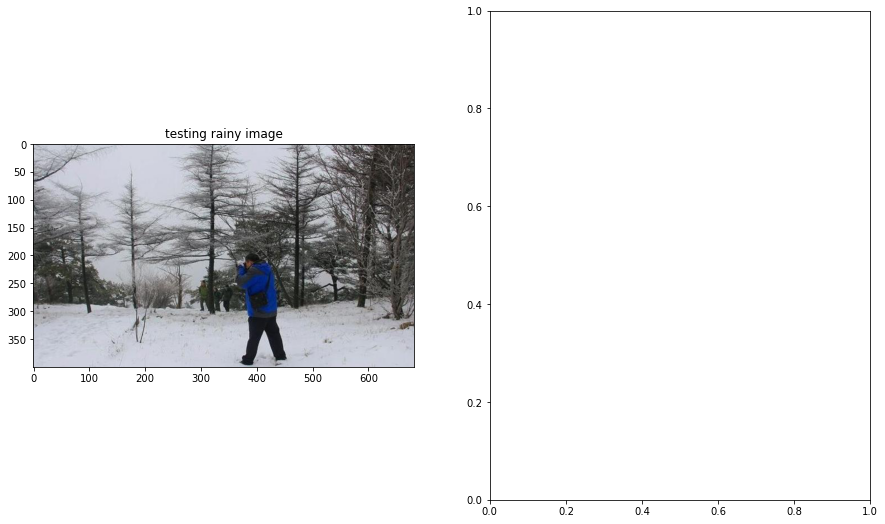

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import os

file1 = infile
file2 = os.path.join(output_path,infile.split("/")[-1])

rcParams['figure.figsize'] = 15 ,9

# read images
testing_img = mpimg.imread(infile)
#generated_img = mpimg.imread(os.path.join(output_path, infile.split("/")[-1]))

# display images
fig, ax = plt.subplots(1,2)
ax[0].set_title("testing rainy image")
ax[0].imshow(testing_img)
#ax[1].set_title("generated derain image")
#ax[1].imshow(generated_img)

In [20]:
!python detect.py --image /home/ubuntu/code/datasets/test/real/113.jpg --output_path /home/ubuntu/code/results_detect/real/detect/113-rain.jpg
!python detect.py --image /home/ubuntu/code/results_detect/real/113.jpg --output_path /home/ubuntu/code/results_detect/real/detect/113.jpg

car: 0.9942
bicycle: 0.9826
car: 0.7967
The image is saved to  /home/ubuntu/code/results_detect/real/detect/113-rain.jpg
process time: 1.6364505290985107
---------------------
car: 0.9966
bicycle: 0.9887
bench: 0.8184
car: 0.8165
The image is saved to  /home/ubuntu/code/results_detect/real/detect/113.jpg
process time: 0.7441680431365967
---------------------


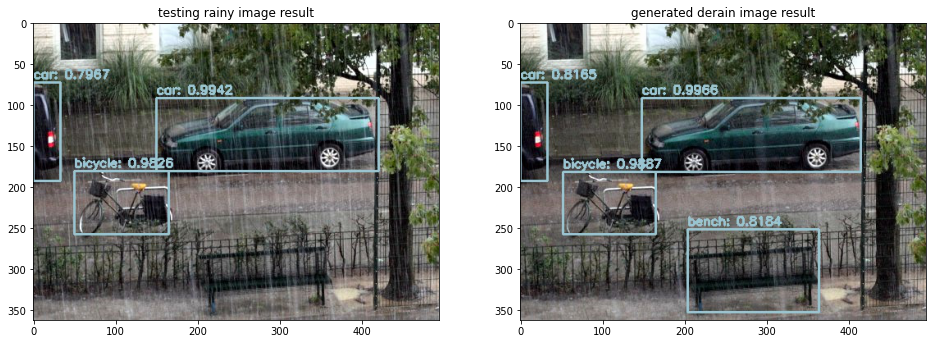

In [21]:
import sys
import os
from PIL import Image

file1 = infile
file2 = os.path.join(output_path,infile.split("/")[-1])
#"/home/ubuntu/code/results_detect/real/detect/113.jpg"

rcParams['figure.figsize'] = 16 ,10

# read images
testing_img = mpimg.imread(file1)
generated_img = mpimg.imread(file2)

# display images
fig, ax = plt.subplots(1,2)
ax[0].set_title("testing rainy image result")
ax[0].imshow(testing_img)
ax[1].set_title("generated derain image result")
ax[1].imshow(generated_img)